In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import torch
from sklearn.model_selection import train_test_split
from dnamite.models import DNAMiteSurvival
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')

In [2]:
data = pd.read_csv("/home/mvanness/dnamite/private_repo/discrete_nam/data/med_paper_pcphf_data_all_term.csv")
X = data.drop([
    "person_id",
    "censor",
    "survival_time",
    'birth_DATETIME', 
    'death_DATE', 
    'index_date', 
    'last_encounter_date',
    'hf_date', 
    'survival_date'
], axis=1)
y = np.array(list(zip(~data["censor"], data["survival_time"])), dtype=[('event', 'bool'), ('time', 'float32')])

cat_cols = [
    'gender', 
    'race',
    'smoking'
]
for col in cat_cols:
    X[col] = X[col].astype("category")
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)    
    

In [3]:
dnamite_cat_cols = [c for c in X_train.columns if 
    c in ["gender", "race", "smoking"]
    or "condition" in c
    or "cat_meas" in c
    or "treatment" in c
]

model = DNAMiteSurvival(
    n_features=X_train.shape[1],
    n_embed=32,
    n_hidden=32,
    n_output=100,
    device=device,
    learning_rate=5e-4,
    categorical_feats=[i for i, c in enumerate(X_train.columns) if c in dnamite_cat_cols],
    kernel_size=10,
    kernel_weight=3,
    pair_kernel_size=4,
    pair_kernel_weight=3,
    batch_size=512,
)
model.fit(X_train, y_train, partialed_feats=["age"])

SPlIT 0
TRAINING PARTIALED FEATS


Early stopping at 21 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING MAINS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
Didn't find selected pair indices. Selecting all pairs.
TRAINING PAIRS


Early stopping at 12 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 1
TRAINING PARTIALED FEATS


Early stopping at 15 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING MAINS


Early stopping at 27 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 13 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 2
TRAINING PARTIALED FEATS


Early stopping at 15 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING MAINS


Early stopping at 6 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 15 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 3
TRAINING PARTIALED FEATS


Early stopping at 16 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING MAINS


Early stopping at 14 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 12 epochs: Test loss has not improved for 5 consecutive epochs.
SPlIT 4
TRAINING PARTIALED FEATS


Early stopping at 25 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING MAINS


Early stopping at 15 epochs: Test loss has not improved for 5 consecutive epochs.
TRAINING PAIRS


Early stopping at 14 epochs: Test loss has not improved for 5 consecutive epochs.


RuntimeError: The size of tensor a (28) must match the size of tensor b (9) at non-singleton dimension 0

In [4]:
model.compute_bin_scores()

In [5]:
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_censored

def get_auc(surv_preds, y_train, y_test, eval_times):
    test_times = np.linspace(
        max(y_train["time"].min(), y_test[y_test["event"] > 0]["time"].min()) + 1e-4,
        min(y_train["time"].max(), y_test[y_test["event"] > 0]["time"].max()) - 1e-4,
        1000
    )
    
    surv_preds = surv_preds[
        :, 
        np.clip(
            np.searchsorted(eval_times.cpu().numpy(), test_times),
            0, surv_preds.shape[1]-1
        )
    ]
    risk_preds = -1 * np.log(np.clip(surv_preds, 1e-5, 10 - 1e-5))
    # Get time-dependent AUC
    _, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_preds, test_times)
    
    # Get cindex
    cindex_time = 365*5
    cindex_time_index = np.searchsorted(test_times, cindex_time)
    cindex = concordance_index_censored(y_test["event"], y_test["time"], risk_preds[:, cindex_time_index])[0]
    
    return mean_auc, cindex

In [6]:
# After fixing categorical features
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

test_preds = model.predict(X_test)
surv_preds = 1 - sigmoid(test_preds)
auc = get_auc(surv_preds, y_train, y_test, model.eval_times)
auc

(0.8419182064923578, 0.851402206951865)

In [7]:
feat_imps = model.get_feature_importances(eval_time=365*5)
feat_imps

,split,feature,importance,n_bins
0,0,gender,0.213442,4
1,0,race,0.063153,7
2,0,smoking,0.180869,8
3,0,age,0.894650,31
4,0,systolic_blood_pressure,0.075242,31
...,...,...,...,...
450,4,glucose || hypertension_treatment,0.000343,93
451,4,glucose || diabetes_treatment,0.000745,93
452,4,diabetes || hypertension_treatment,0.000003,9
453,4,diabetes || diabetes_treatment,0.000037,9


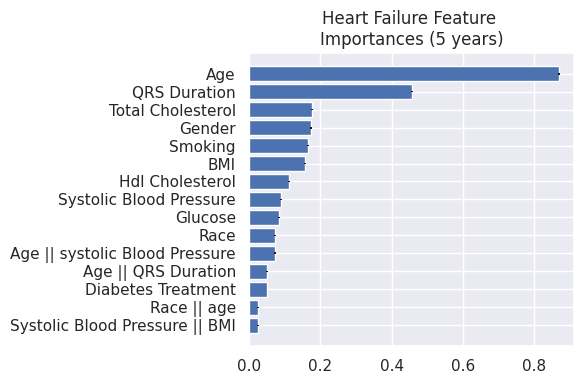

In [8]:
# Find the top k features by mean importance

plt.figure(figsize=(6, 4))

k = 15
top_k_features = feat_imps.groupby("feature")["importance"].agg(["mean", "sem"])
top_k_features = top_k_features.sort_values("mean", ascending=True).tail(k)

# Custom function to replace underscores with spaces and capitalize the first letter of each word
def custom_capitalize(s):
    return ' '.join(word[0].upper() + word[1:] for word in s.split('_'))

top_k_features.index = top_k_features.index.map(custom_capitalize)
# top_k_features

plt.barh(top_k_features.index, top_k_features["mean"], yerr=1.96*top_k_features["sem"])
plt.title("Heart Failure Feature \nImportances (5 years)")

plt.tight_layout()

In [58]:
ord_encoder = model.preprocessor.transformers_[0][1]

In [62]:
cat_col = "race"
shape_data = model.get_shape_function(cat_col, eval_time=365*5, is_cat_col=True)

feat_index = np.where(ord_encoder.feature_names_in_ == cat_col)[0][0]
cat_feat_map = {-1: "NA"}
for i, cat in enumerate(ord_encoder.categories_[feat_index]):
    cat_feat_map[i] = cat
    
shape_data["bin"] = shape_data["bin"].map(cat_feat_map)
shape_data

,feature,bin,score,count,split
0,race,NA,-0.168493,0.0,0
1,race,American Indian,-0.073765,614.0,0
2,race,Asian,0.086795,41364.0,0
3,race,Black,0.245657,7461.0,0
4,race,Hawaiian,0.263056,1573.0,0
5,race,Unknown,0.107905,29624.0,0
6,race,White,-0.100440,89487.0,0
0,race,NA,-0.192507,0.0,1
1,race,American Indian,-0.231182,600.0,1
2,race,Asian,-0.124263,41356.0,1


PAIR BIN VALUES (900, 2)
PAIR BIN VALUES (900, 2)
PAIR BIN VALUES (900, 2)
PAIR BIN VALUES (900, 2)
PAIR BIN VALUES (900, 2)


<AxesSubplot: xlabel='systolic_blood_pressure', ylabel='age'>

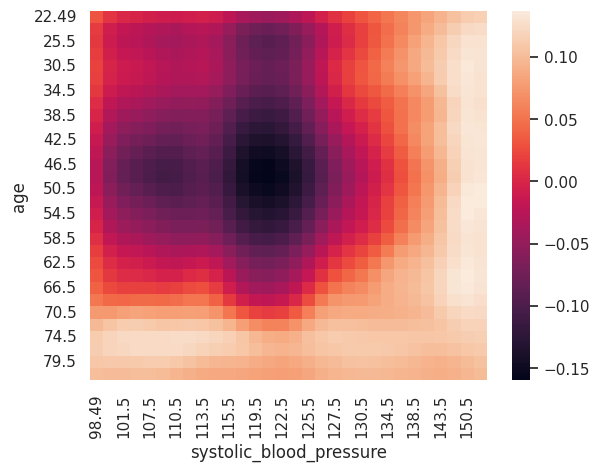

In [9]:
col1 = "age"
col2 = "systolic_blood_pressure"

pair_scores, pair_values = model.get_pair_shape_function(col1, col2, eval_time=365*5)

pair_scores = np.mean(np.stack(pair_scores), axis=0)
pair_values = pair_values[0]

pair_data_dnamite = pd.DataFrame({
    col1: pair_values[:, 0],
    col2: pair_values[:, 1],
    "score": pair_scores
})

pair_data_dnamite = pair_data_dnamite.pivot(
    index=col1, 
    columns=col2, 
    values="score"
)

# Round the values in the columns and index
# Round the index and columns to 3 decimal places and reassign
pair_data_dnamite.index = pair_data_dnamite.index.to_series().round(3)
pair_data_dnamite.columns = pair_data_dnamite.columns.to_series().round(3)

sns.heatmap(pair_data_dnamite)

In [69]:
pair_scores.shape

(180,)

In [70]:
pair_values.shape

(210, 2)

PAIR BIN SCORES (217,)
PAIR BIN SCORES (210,)
PAIR BIN VALUES (210, 2)
PAIR BIN SCORES (217,)
PAIR BIN SCORES (210,)
PAIR BIN VALUES (210, 2)
PAIR BIN SCORES (217,)
PAIR BIN SCORES (210,)
PAIR BIN VALUES (210, 2)
PAIR BIN SCORES (217,)
PAIR BIN SCORES (210,)
PAIR BIN VALUES (210, 2)
PAIR BIN SCORES (217,)
PAIR BIN SCORES (210,)
PAIR BIN VALUES (210, 2)


<AxesSubplot: xlabel='race', ylabel='age'>

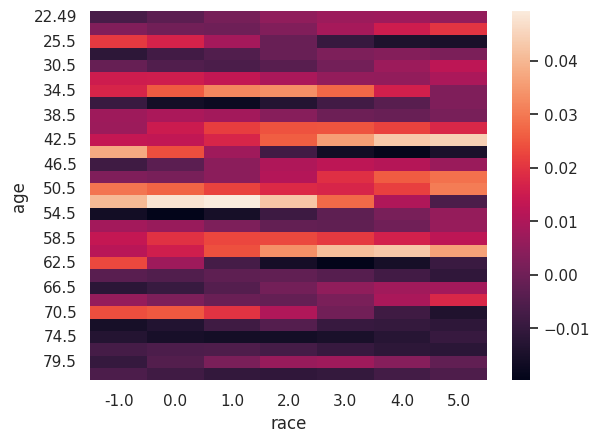

In [75]:
col1 = "age"
col2 = "race"

pair_scores, pair_values = model.get_pair_shape_function(col1, col2, eval_time=365*5, is_feat2_cat_col=True)

pair_scores = np.mean(np.stack(pair_scores), axis=0)
pair_values = pair_values[0]

pair_data_dnamite = pd.DataFrame({
    col1: pair_values[:, 0],
    col2: pair_values[:, 1],
    "score": pair_scores
})

pair_data_dnamite = pair_data_dnamite.pivot(
    index=col1, 
    columns=col2, 
    values="score"
)

# Round the values in the columns and index
# Round the index and columns to 3 decimal places and reassign
pair_data_dnamite.index = pair_data_dnamite.index.to_series().round(3)
pair_data_dnamite.columns = pair_data_dnamite.columns.to_series().round(3)

sns.heatmap(pair_data_dnamite)